<div class="alert alert-block alert-info">
    <h1><b>CAPSTONE PROJECT: THE BATTLE OF THE NEIGHBOURHOODS</b></h1>
    <h3>The Capstone project for the Applied Data Science Certificate</h3>
    <p> By: Sarwat Sohail. </p>
</div>

***

#### TABLE OF CONTENTS

-  [Introduction: Business Problem](#Introduction)
-  [Data and its sources](#Data-and-its-sources)
-  [Methodology](#Methodology)
    -  [Importing relevant libraries](#Importing-relevant-libraries)
    -  [Cleaning and filtering data](#Cleaning-and-filtering-data)
    -  [Displaying the neighbourhoods of Toronto](#Displaying-the-neighbourhoods-of-Toronto)
    -  [Exploratory analysis of the restaurants of Toronto](#Exploratory-analysis-of-the-restaurants-of-Toronto)
    -  [Neighbourhoods by no. of people with Pakistani ethnicity](#Neighbourhoods-by-no.-of-people-with-Pakistani-ethnicity)
    -  [Analyzing the data further to find the optimum neighbourhood](#Analyzing-the-data-further-to-find-the-optimum-neighbourhood)
-  [Results and Discussion](#Results-and-Discussion)
-  [Conclusion](#Conclusion)

## Introduction: Business Problem

In this Capstone Project, we are going to find the best neighbourhood to open a restaurant in the city of Toronto, Canada. Points to consider:

1. It must be close, but not too close to a major food street, as that is likely where people might converge for eating.
2. It must be close enough to the Pakistani diaspora.

## Data and its sources

The data that we will use in this project mainly comes from two sources: 

- The Neighbourhood Profiles from the 2016 Census Data, obtained from the City of Toronto's open data portal.

- The location data for the restaurants in the city, obtained from the Foursquare location data through its API. 

In addition, we will also use data we obtained previously by scraping Wikipedia, as well as use the geocoders API to get some additional location data.

## Methodology

### Importing relevant libraries

In [1]:
import pandas as pd
import numpy as np
from geopy.geocoders import Nominatim
import folium
import urllib.request, urllib.parse, urllib.error
from bs4 import BeautifulSoup
import ssl
from matplotlib import pyplot as plt
import json
import requests
from sklearn.cluster import KMeans
import random


### Cleaning and filtering data

Now we import or download our data. 

Firstly, we will get the locations of all 140 neighbourhoods of Toronto. This data was previously scraped from Wikipedia's page on Toronto's neighbourhoods.

In [2]:
tor_ngh_data = pd.read_csv('tor_neighbourhood_locations.csv').drop('Unnamed: 0', axis = 1)
tor_ngh_data.head()

,Borough,Location,Latitude,Longitude,Neighbourhoods covered
0,Scarborough,Agincourt North,43.808038,-79.266439,Agincourt and Brimwood
1,Scarborough,Agincourt South-Malvern West,43.781969,-79.257689,Agincourt and Malvern
2,Etobicoke,Alderwood,43.601717,-79.545232,Alderwood
3,Old City of Toronto,Annex,43.670338,-79.407117,The Annex and Seaton Village
4,North York,Banbury-Don Mills,43.670338,-79.407117,Don Mills


Then, we move onto obtaining the Foursquare location data:

In [ ]:
def get_all_venues(latitude, longitude, neighbourhood, borough):
    
    final_dff = []
    
    CLIENT_ID ='WU2R1DNGLYATXFKLN5ITK0HXJEZR3YGYLXLUJTAY3VHPL53Z' 
    CLIENT_SECRET = 'GGGU5VRJL14XJBW3X3AN0VX50UO3GSSD1OS3X5BECJ0X5KC4' 
    ACCESS_TOKEN = 'ZDDLZJZUUWYMMU0151BLSD5BKBY5Z01D2P0LBO0UGV0VZ55Q' 
    VERSION = '20210816' 
    LIMIT = 150 
    radius = 500

    for lat, lng, ngh, bor in zip(latitude, longitude, neighbourhood, borough):
        neighborhood_latitude = lat
        neighborhood_longitude = lng
        neighborhood_name = ngh 
    
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID,CLIENT_SECRET,VERSION,lat,lng,radius,LIMIT)
        
        results = requests.get(url).json()['response']['groups'][0]['items']
        try:
            for ra in range(len(results)):
                row = {
                   'Neighbourhood':ngh, 'Borough': bor, 'Neighbourhood_Latitude':lat,'Neighbourhood_Longitude':lng,
                   'Venue':results[ra]['venue']['name'],'Venue_Latitude':results[ra]['venue']['location']['lat'],
                   'Venue_Longitude':results[ra]['venue']['location']['lng'],
                   'Venue_Category':results[ra]['venue']['categories'][0]['name']
               }
                final_dff.append(row)
                
        except Exception as err:
            print('Error occured:', err, ', skip row')
    
    ret_df = pd.DataFrame(final_dff)
    return ret_df

In [ ]:
tor_venues = get_all_venues(tor_ngh_data['Latitude'], tor_ngh_data['Longitude'], tor_ngh_data['Location'], tor_ngh_data['Borough'])

In [4]:
tor_venues.head()

,Unnamed: 0,Neighbourhood,Borough,Neighbourhood_Latitude,Neighbourhood_Longitude,Venue,Venue_Latitude,Venue_Longitude,Venue_Category
0,0,Agincourt North,Scarborough,43.808038,-79.266439,Menchie's,43.808338,-79.268288,Frozen Yogurt Shop
1,1,Agincourt North,Scarborough,43.808038,-79.266439,Saravanaa Bhavan South Indian Restaurant,43.810117,-79.269275,Indian Restaurant
2,2,Agincourt North,Scarborough,43.808038,-79.266439,Congee Town 太皇名粥,43.809035,-79.267634,Chinese Restaurant
3,3,Agincourt North,Scarborough,43.808038,-79.266439,Shoppers Drug Mart,43.808894,-79.269854,Pharmacy
4,4,Agincourt North,Scarborough,43.808038,-79.266439,Booster Juice,43.809915,-79.269382,Juice Bar


We filter out all the resturants, removing other kinds of venues

In [5]:
resturants = tor_venues.loc[tor_venues['Venue_Category'].str.contains('Restaurant')]

In [6]:
resturants.tail()

,Unnamed: 0,Neighbourhood,Borough,Neighbourhood_Latitude,Neighbourhood_Longitude,Venue,Venue_Latitude,Venue_Longitude,Venue_Category
2832,2832,York University Heights,North York,43.758781,-79.519434,Pita Land,43.757520,-79.514628,Falafel Restaurant
2838,2838,Yorkdale-Glen Park,North York,43.703434,-79.452918,McDonald's,43.704919,-79.452238,Fast Food Restaurant
2839,2839,Yorkdale-Glen Park,North York,43.703434,-79.452918,Sky Ranch Restaurant,43.700730,-79.451684,Argentinian Restaurant
2841,2841,Yorkdale-Glen Park,North York,43.703434,-79.452918,Darosa,43.706970,-79.453121,Mediterranean Restaurant
2845,2845,Yorkdale-Glen Park,North York,43.703434,-79.452918,Il vagabondo,43.701480,-79.452443,Italian Restaurant


In [7]:
resturants.shape

(744, 9)

Then we import our neighbourhood profiles. This is the largest dataset, and consequently the one which requires the most cleaning.

In [8]:
# The webpage from which I downloaded this dataset is: https://open.toronto.ca/dataset/neighbourhood-profiles/
# Since it is huge, I have downloaded it previously and stored it in my github

df = pd.read_csv('neighbourhood-profiles-2016-csv.csv')

First we check the shape of the dataframe:

In [9]:
print(f'The number of rows in the Neighbourhood Profile dataframe are :{df.shape[0]} and the number of columns are: {df.shape[1]}. Each row represents a characteristic of the population, while the columns represent the neighbourhoods.')

The number of rows in the Neighbourhood Profile dataframe are :2383 and the number of columns are: 146. Each row represents a characteristic of the population, while the columns represent the neighbourhoods.


We find those characteristics which are related to Pakistan:

In [10]:
df.loc[df['Characteristic'].str.contains('Pakistan')]

,_id,Category,Topic,Data Source,Characteristic,City of Toronto,Agincourt North,Agincourt South-Malvern West,Alderwood,Annex,...,Willowdale West,Willowridge-Martingrove-Richview,Woburn,Woodbine Corridor,Woodbine-Lumsden,Wychwood,Yonge-Eglinton,Yonge-St.Clair,York University Heights,Yorkdale-Glen Park
1221,1222,Immigration and citizenship,Immigrants by selected place of birth,Census Profile 98-316-X2016001,Pakistan,"34,750",295,435,15,135,...,50,540,"1,550",95,35,10,15,30,505,20
1278,1279,Immigration and citizenship,Recent immigrants by selected place of birth,Census Profile 98-316-X2016001,Pakistan,"6,725",50,35,0,30,...,20,120,305,0,0,0,0,0,175,0
1591,1592,Ethnic origin,Ethnic origin population,Census Profile 98-316-X2016001,Pakistani,"36,135",230,410,50,125,...,30,590,"1,605",80,55,10,40,55,515,35


We get three rows, two of which are in the Immigration and Citizenship, and one of which is in Ethnic Origin. We shall select the latter, as it could be a better indicator of cuisine taste.

In [11]:
pak_eth = df.iloc[1591].T.reset_index()

total_pak_eth = pak_eth.iloc[5,:]

pak_eth.drop([0,1, 2, 3, 4, 5], axis = 0, inplace = True)
pak_eth.columns = ['Neighbourhood', 'Pop. with Pakistani ethnicity']
pak_eth.reset_index(drop = True, inplace = True)

In [12]:
pak_eth.head()

,Neighbourhood,Pop. with Pakistani ethnicity
0,Agincourt North,230
1,Agincourt South-Malvern West,410
2,Alderwood,50
3,Annex,125
4,Banbury-Don Mills,325


We see above our table above shows the number of people of Pakistani ethnici origin in each neighbourhood of Toronto. We can also see the total number of people of Pakistani origin in Toronto with the following:

In [13]:
print('Total number of people of Pakistani origin in Toronto: {}'.format(total_pak_eth.iloc[1]))

Total number of people of Pakistani origin in Toronto: 36,135


There is still a problem with the table above: all the numberical values are actually strings, as seen below:

In [14]:
pak_eth['Pop. with Pakistani ethnicity'].dtypes

dtype('O')

We need to convert them all to int to construct our chart. For this we clean the data the following way:

In [15]:
for i in range(len(pak_eth['Pop. with Pakistani ethnicity'])):
    pak_eth['Pop. with Pakistani ethnicity'][i] = pak_eth['Pop. with Pakistani ethnicity'][i].replace(',', '')

pak_eth['Pop. with Pakistani ethnicity'] = pak_eth['Pop. with Pakistani ethnicity'].astype(int)

Now we can see their type:

In [16]:
pak_eth['Pop. with Pakistani ethnicity'].dtypes

dtype('int32')

According to the above, there are 744 separate entries.

### Displaying the neighbourhoods of Toronto

Now, to better understand where each neighbourhood lies, we will display the 140 neighbourhoods of Toronto using Folium maps. For this, we shall first get Toronto's location using the geocoders API:

In [17]:
toronto_address = 'Toronto, Canada'

geolocator = Nominatim(user_agent='explore_toronto')
location = geolocator.geocode(toronto_address)
t_latitude = location.latitude
t_longitude = location.longitude
print('The geograpical coordinate of Toronto, Canada are {}, {}.'.format(t_latitude, t_longitude))

The geograpical coordinate of Toronto, Canada are 43.6534817, -79.3839347.


Then we write a function and create a dict to associate each neighbourhood with a different colour. 

In [81]:
def get_color_list():
    hexadecimal_alphabets = '0123456789ABCDEF'
    colour = "#" + ''.join([random.choice(hexadecimal_alphabets) for j in range(6)])
    return colour

ngh_colours = {}
for neighbourhood in tor_ngh_data['Location']:
    colour = get_color_list()
    ngh_colours.update({neighbourhood: colour})

Now we draw the map:

In [19]:
toronto_map = folium.Map(location = [t_latitude, t_longitude], zoom_start = 11)

for lat, lng, ngh, bor in zip(tor_ngh_data['Latitude'], tor_ngh_data['Longitude'], tor_ngh_data['Location'], tor_ngh_data['Borough']):
    label = '{}, {}'.format(ngh, bor)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color= 'green',
        fill = True,
        fill_color = 'green',
        opacity = 0.9,
        parse_html=False).add_to(toronto_map) 

    
toronto_map

Here we see all the neighbourhoods of Toronto. Clicking on each will bring up its name and borough.

### Exploratory analysis of the restaurants of Toronto

Now we pinpoint all the restaurants we have located on the map of Toronto itself. 

In [20]:
r_toronto_map = folium.Map(location = [t_latitude, t_longitude], zoom_start = 11)

for ngh in resturants['Neighbourhood'].unique():
    row = tor_ngh_data.loc[tor_ngh_data['Location'] == ngh]
    nlat = row['Latitude']
    nlng = row['Longitude']
    nbor = row['Borough']
    label = '{}, {}'.format(ngh, nbor)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [nlat, nlng],
        radius=12,
        popup=label,
        color=ngh_colours[ngh],
        parse_html=False).add_to(r_toronto_map) 


for lat, lng, neighbourhood, category in zip(
    resturants['Venue_Latitude'], resturants['Venue_Longitude'], 
    resturants['Neighbourhood'], resturants['Venue_Category']):
    label = '{}, {}'.format(neighbourhood, category)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color= ngh_colours[neighbourhood],
        fill=True,
        fill_color= ngh_colours[neighbourhood],
        fill_opacity=0.8,
        parse_html=False).add_to(r_toronto_map)  
    
r_toronto_map

Here we see that the neighbourhoods with the greatest number of restaurants are near the coastline and the eastern side of Toronto.

Now, we cluster the restaurants by KMeans. We get all latitudes and longitudes:

In [21]:
reslatlng = []
for lat, lng in zip(resturants['Venue_Latitude'], resturants['Venue_Longitude']):
    row =[lat, lng]
    reslatlng.append(row)

We try a range of k values to find the optimum one:

In [22]:
inertias = []
mapping = {}
K = range(1, 10)

for k in K:
    kmeans = KMeans(n_clusters = k, random_state = 0).fit(reslatlng)
    inertias.append(kmeans.inertia_)
    mapping[k] = kmeans.inertia_


In [23]:
for key, val in mapping.items():
    print(f'{key} : {val}')

1 : 5.708182349269557
2 : 2.8516235514864547
3 : 1.8431911877689795
4 : 1.3107970953613848
5 : 0.9445875363583698
6 : 0.7686466763204448
7 : 0.610373712298232
8 : 0.486216371676208
9 : 0.41900318381219015


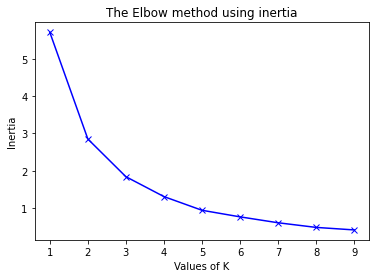

In [24]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow method using inertia')
plt.show()

Our data has no sharply defined elbow point, but the best one appears to be at k = 4. We will use this k-value to create our clusters.

In [25]:
reskmeans = KMeans(n_clusters = 4, random_state = 0).fit(reslatlng)

In [26]:
reskmeans.labels_[0:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [27]:
resturants.insert(0, 'Cluster Label', reskmeans.labels_)

In [28]:
resturants.tail()

,Cluster Label,Unnamed: 0,Neighbourhood,Borough,Neighbourhood_Latitude,Neighbourhood_Longitude,Venue,Venue_Latitude,Venue_Longitude,Venue_Category
2832,2,2832,York University Heights,North York,43.758781,-79.519434,Pita Land,43.757520,-79.514628,Falafel Restaurant
2838,2,2838,Yorkdale-Glen Park,North York,43.703434,-79.452918,McDonald's,43.704919,-79.452238,Fast Food Restaurant
2839,2,2839,Yorkdale-Glen Park,North York,43.703434,-79.452918,Sky Ranch Restaurant,43.700730,-79.451684,Argentinian Restaurant
2841,2,2841,Yorkdale-Glen Park,North York,43.703434,-79.452918,Darosa,43.706970,-79.453121,Mediterranean Restaurant
2845,2,2845,Yorkdale-Glen Park,North York,43.703434,-79.452918,Il vagabondo,43.701480,-79.452443,Italian Restaurant


As shown, the clusters have been inserted into the dataframe. We can group by cluster to see how big each one is:

In [29]:
resturants.groupby('Cluster Label').count()

,Unnamed: 0,Neighbourhood,Borough,Neighbourhood_Latitude,Neighbourhood_Longitude,Venue,Venue_Latitude,Venue_Longitude,Venue_Category
Cluster Label,,,,,,,,,
0,87,87,87,87,87,87,87,87,87
1,113,113,113,113,113,113,113,113,113
2,131,131,131,131,131,131,131,131,131
3,413,413,413,413,413,413,413,413,413


We can also colour-code the restaurants, and draw the clusters onto the map once again:

In [30]:
res_cluster_map = folium.Map(location = [t_latitude, t_longitude], zoom_start = 11)

cluster_colours = ['red', 'blue', 'green', 'yellow']


for i in range(len(resturants['Cluster Label'].unique())):
    temp = resturants.loc[resturants['Cluster Label'] == resturants['Cluster Label'].unique()[i]]
    cluster_colour = cluster_colours[i]
    
    for lat, lng, neighbourhood, category in zip(
    temp['Venue_Latitude'], temp['Venue_Longitude'], 
    temp['Neighbourhood'], temp['Venue_Category']):
        label = '{}, {}'.format(neighbourhood, category)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=2,
            popup=label,
            color= cluster_colour,
            fill=True,
            fill_color= cluster_colour,
            fill_opacity=0.3,
            parse_html=False).add_to(res_cluster_map)  



res_cluster_map

We can also create a bubble map to show the relative strengths (ie., number of data points) of these clusters. For this, we first turn the clusters into a table:

In [31]:
cluster_colours = ['red', 'blue', 'green', 'yellow']

clusters_data = []

for i in range(len(resturants['Cluster Label'].unique())):
    temp = resturants.loc[resturants['Cluster Label'] == resturants['Cluster Label'].unique()[i]]
    cluster_colour = cluster_colours[i]
    xvals = []
    yvals = []
    count = 0
    
    for lat, lng in zip(
    temp['Venue_Latitude'], temp['Venue_Longitude']):
        xvals.append(lat)
        yvals.append(lng)
        count += 1
        
    row = {'Cluster Label' : resturants['Cluster Label'].unique()[i], 'Latitude' : np.mean(xvals), 'Longitude' : np.mean(yvals), 'Size' : count, 'Colour' : cluster_colour}
    
    clusters_data.append(row)


In [32]:
clusters = pd.DataFrame(clusters_data)

In [33]:
res_cluster_map2 = folium.Map(location = [t_latitude, t_longitude], zoom_start = 11)

for clabel, lat, lng, size, color in zip(clusters['Cluster Label'], clusters['Latitude'], clusters['Longitude'], clusters['Size'], clusters['Colour']):
    label = 'Cluster: {}\nNo. of restaurants: {}'.format(clabel, size)
    label = folium.Popup(label, parse_html=True)
    folium.Circle(
            [lat, lng],
            radius= size * 10,
            popup=label,
            color= color,
            fill=True,
            fill_color= color,
            fill_opacity=0.3,
            parse_html=False).add_to(res_cluster_map2)  
    
res_cluster_map2

And now we can see above, the strengths of the four clusters relative to each other.

#### Now we groupby neighbourhood to see the number of restaurants by neighbourhood:

In [34]:
restaurant_sort = (
    resturants
    .groupby(['Neighbourhood', 'Borough'], as_index = False)
    .agg(Total = ('Venue', 'count'))
    .sort_values('Total', ascending = True)
)    

In [35]:
restaurant_sort.reset_index(drop = True).tail(10)

,Neighbourhood,Borough,Total
90,Playter Estates-Danforth,Old City of Toronto,16
91,Wychwood,Old City of Toronto,17
92,Yonge-St.Clair,Old City of Toronto,19
93,Dufferin Grove,Old City of Toronto,20
94,Yonge and Eglinton,Old City of Toronto,20
95,Milliken,Scarborough,21
96,Hillcrest Village,North York,22
97,Church-Yonge Corridor,Old City of Toronto,25
98,Clairlea-Birchmount,Scarborough,25
99,Bay Street Corridor,Old City of Toronto,31


In [36]:
restaurant_sort.loc[restaurant_sort['Total'] <= 5].count()

Neighbourhood    56
Borough          56
Total            56
dtype: int64

In [37]:
restaurant_sort.shape

(100, 3)

The above shows us an interesting thing - that only 100 out of the 140 neighbourhoods have any restaurants at all. Also, 56 of them have 5 or less than 5 restaurants, proving that there only 44 neighbourhoods where there are any restaruants. This gives an indication that these neighbourhoods would be better to open a restaurant, that is, a restaurant opening there might have a better chance for success.

We visualize the number of restaurants per neighbourhoods:

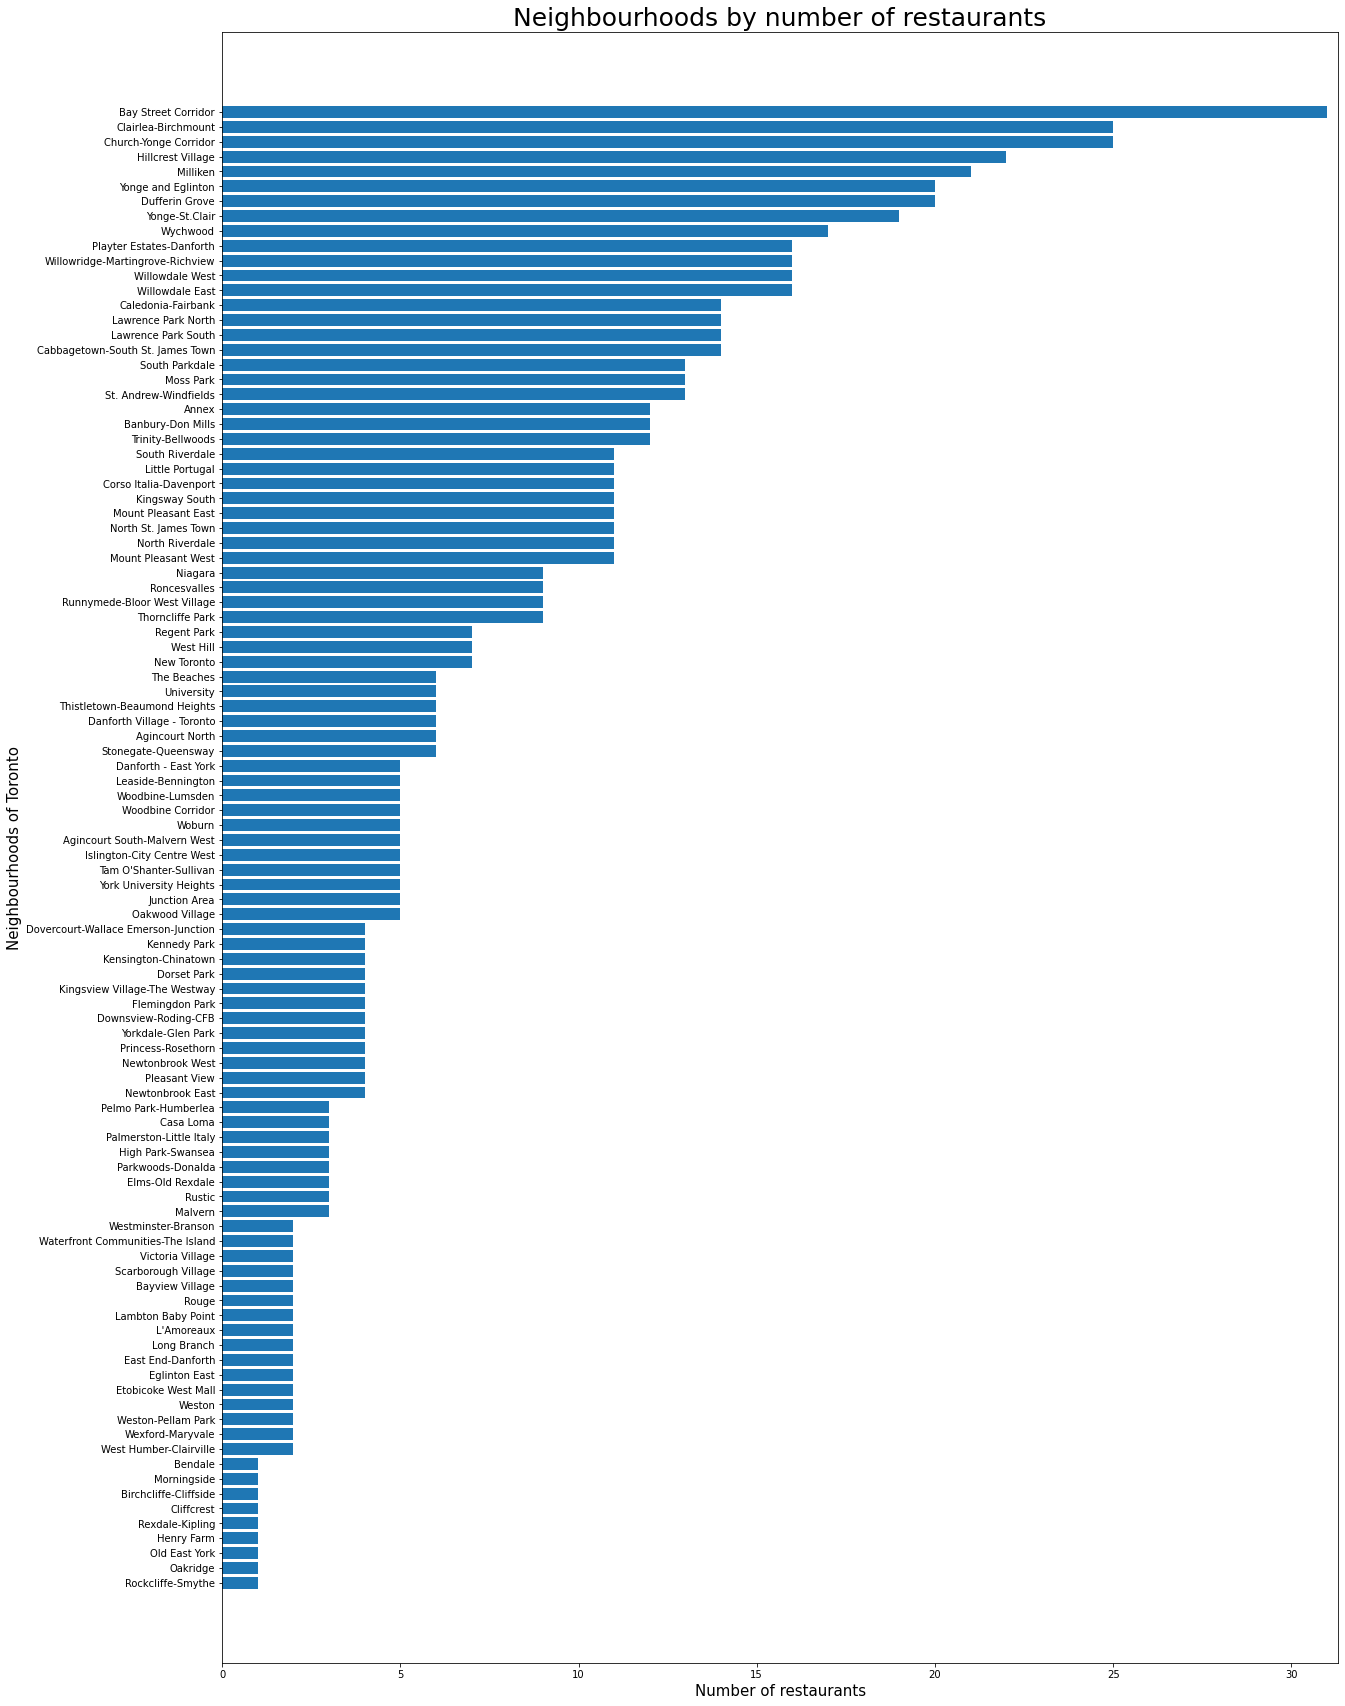

In [38]:
plt.figure(figsize = (20, 30))
plt.margins(0.01, 0.05)
plt.barh(restaurant_sort['Neighbourhood'], restaurant_sort['Total'])
plt.ylabel('Neighbourhoods of Toronto', fontdict = {'fontsize': 15})
plt.xlabel('Number of restaurants', fontdict = {'fontsize': 15})
plt.title('Neighbourhoods by number of restaurants', fontdict = {'fontsize': 25})
plt.show()

In [39]:
restaurant_sort.sort_values(by = 'Total', ascending = False).head(10)

,Neighbourhood,Borough,Total
4,Bay Street Corridor,Old City of Toronto,31
12,Clairlea-Birchmount,Scarborough,25
11,Church-Yonge Corridor,Old City of Toronto,25
28,Hillcrest Village,North York,22
43,Milliken,Scarborough,21
96,Yonge and Eglinton,Old City of Toronto,20
20,Dufferin Grove,Old City of Toronto,20
97,Yonge-St.Clair,Old City of Toronto,19
95,Wychwood,Old City of Toronto,17
91,Willowridge-Martingrove-Richview,Etobicoke,16


Above we have a visual representation of the neighbourhoods with the greatest number of restaurants, and below that a table showing the top ten neighbourhoods in terms of number of restaurants. 

We can also look at the borough with the greatest number of neighbourhoods having restaurants:

In [40]:
restaurant_sort.groupby(['Borough']).count().sort_values(by = 'Total', ascending = False).head(5)

,Neighbourhood,Total
Borough,,
Old City of Toronto,38,38
Scarborough,20,20
North York,19,19
Etobicoke,13,13
East York,5,5


The above shows the neighbourhoods and the boroughs with the greatest number of restaurants.

We now group the data by cuisine, to see where Pakistani restaurants land:

In [41]:
restype = (
    resturants
    .groupby(['Venue_Category'], as_index = False)
    .agg(Total = ('Venue', 'count'))
    .sort_values('Total', ascending = True)
)

restype.reset_index(drop = True, inplace = True)

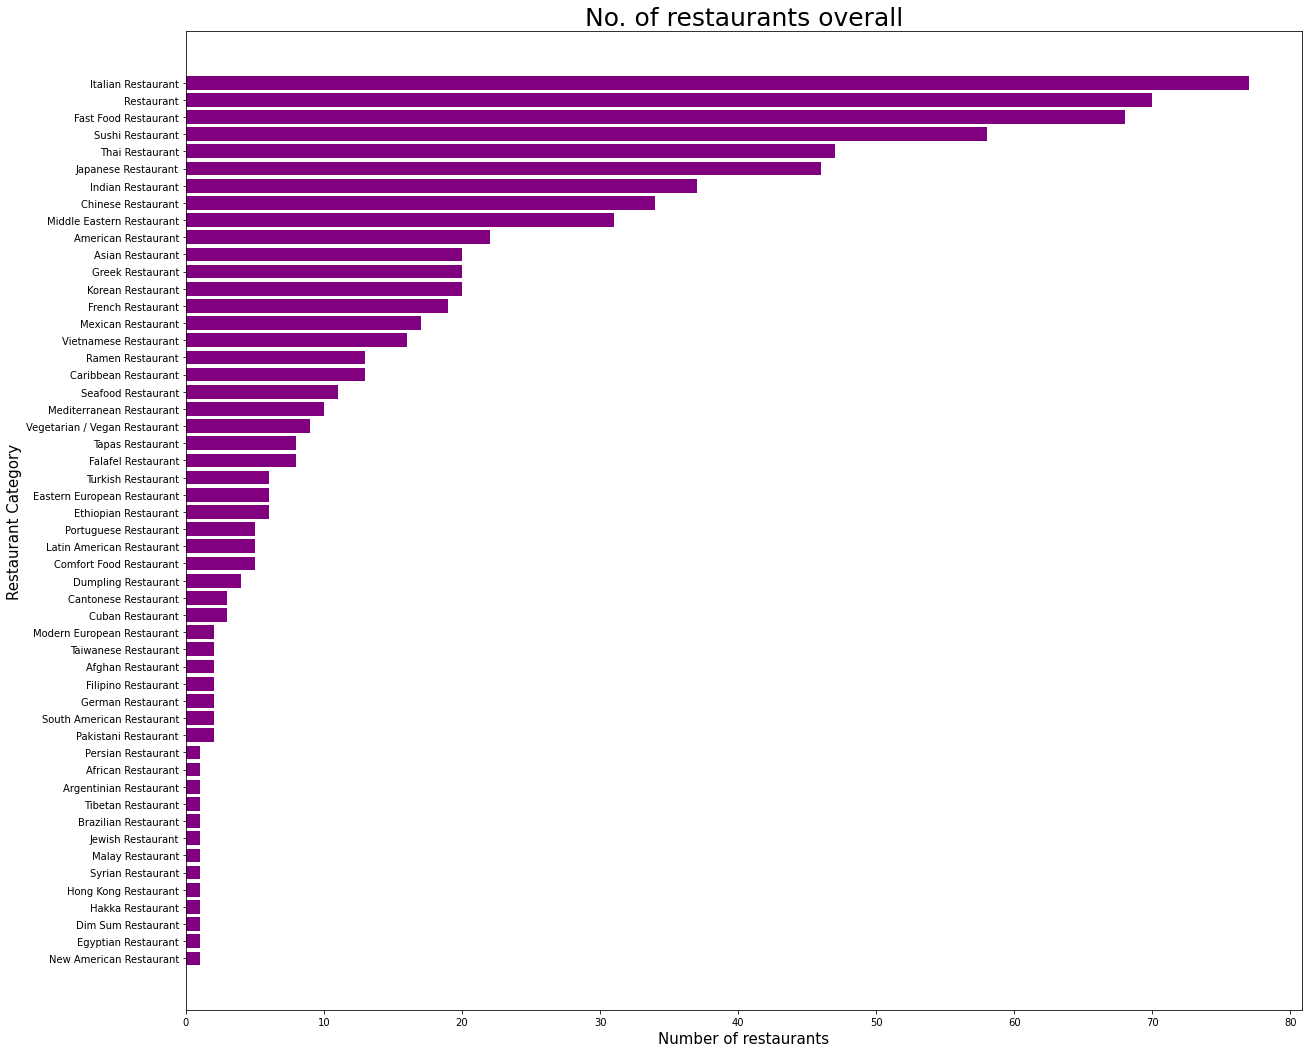

In [42]:
plt.figure(figsize = (20, 18))
plt.barh(restype['Venue_Category'], restype['Total'], color = 'purple')
plt.ylabel('Restaurant Category', fontdict = {'fontsize': 15})
plt.xlabel('Number of restaurants', fontdict = {'fontsize': 15})
plt.title('No. of restaurants overall', fontdict = {'fontsize': 25})
plt.show()

According to the bar chart above, Italian Restaurants are the most popular, followed by restaurants with no particular bent of cuisine. Unfortunately(or maybe fortunately), there aren't many Pakistani Restaurants. We shall see how many there are exactly: 

In [43]:
restype.loc[restype['Venue_Category'] == 'Pakistani Restaurant']

,Venue_Category,Total
13,Pakistani Restaurant,2


This shows that there are only two restaurants in Pakistan serving Pakistani cuisine, which may be better for us in the long run. We can check which neighbourhoods these restaurants are in:

In [44]:
pak_res = resturants.loc[resturants['Venue_Category'] == 'Pakistani Restaurant']
pak_res

,Cluster Label,Unnamed: 0,Neighbourhood,Borough,Neighbourhood_Latitude,Neighbourhood_Longitude,Venue,Venue_Latitude,Venue_Longitude,Venue_Category
817,3,817,Flemingdon Park,North York,43.718432,-79.333204,Shaheen Tikka & Kabab House,43.714011,-79.334296,Pakistani Restaurant
1319,3,1319,Moss Park,Old City of Toronto,43.654644,-79.369728,King's Place647-352-0786,43.658278,-79.370925,Pakistani Restaurant


We check the two neighbourhoods that have Pakistani restaurants to see what they are like overall:

In [45]:
restaurant_sort.loc[(restaurant_sort['Neighbourhood'] == 'Flemingdon Park') | (restaurant_sort['Neighbourhood'] == 'Moss Park')]

,Neighbourhood,Borough,Total
25,Flemingdon Park,North York,4
45,Moss Park,Old City of Toronto,13


From the dataframe above, we can see that Flemingdon Park has only 4 restaurants, while Moss Park has 13. 

### Neighbourhoods by no. of people with Pakistani ethnicity

#### Bar chart showing all neighbourhoods by the number of Pakistani origin people:

To find the optimum place to open a restaurant, we need to see which neighbourhoods have a high to moderate Pakistani population, as they have a higher chance of enjoying the cuisine. We have already imported and cleaned the dataset of neighbourhood profiles, now we will plot the data onto a bar chart:

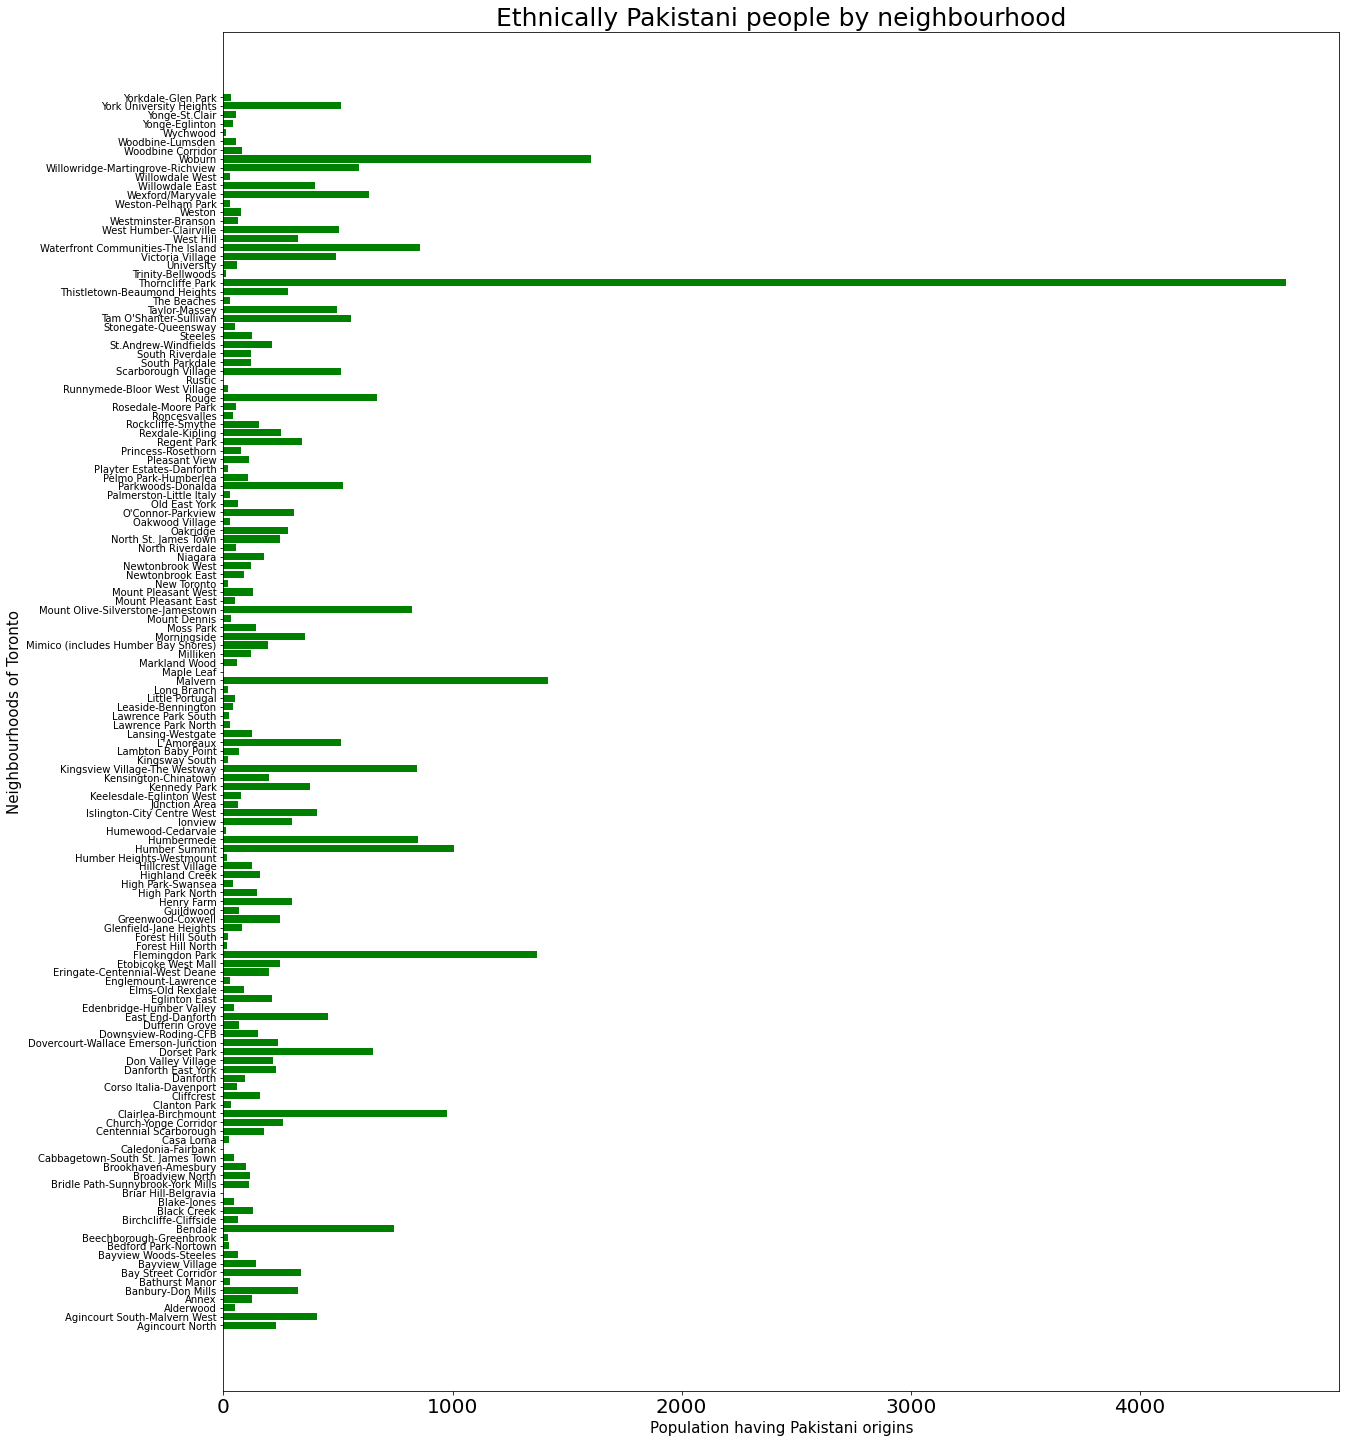

In [46]:
plt.figure(figsize =(20, 25))
plt.barh(pak_eth['Neighbourhood'], pak_eth['Pop. with Pakistani ethnicity'], color = 'green')
plt.xticks(fontsize=20)
plt.ylabel('Neighbourhoods of Toronto', fontdict = {'fontsize': 15})
plt.xlabel('Population having Pakistani origins', fontdict = {'fontsize': 15})
plt.title('Ethnically Pakistani people by neighbourhood', fontdict = {'fontsize': 25})
plt.show()

Most neighbourhoods have few people of Pakistani origin; however, Thorncliffe Park stands out with the greatest number. It would be interesting to see the distance between Thorncliffe Park and the two neighbourhoods that have Pakistani restaurants. 

In fact, a location which minimizes the distance between the top 5 locales with the greatest number of Pakistani ethnicity people would be even more helpful.

In [47]:
thorncliffe = pak_eth.loc[pak_eth['Neighbourhood'] == 'Thorncliffe Park']
thorncliffe

,Neighbourhood,Pop. with Pakistani ethnicity
118,Thorncliffe Park,4640


In [48]:
thorn_coords = tor_ngh_data.loc[tor_ngh_data['Location'] == 'Thorncliffe Park']
thorn_coords

,Borough,Location,Latitude,Longitude,Neighbourhoods covered
118,East York,Thorncliffe Park,43.704553,-79.345407,NaN


In [49]:
thorn_lat = thorn_coords.iloc[0,2]
thorn_lng = thorn_coords.iloc[0,3]
thorn_ngh = thorn_coords.iloc[0,1]
thorn_bor = thorn_coords.iloc[0,0]
thorn_pop = thorncliffe.iloc[0,1]

In [50]:
pak_res_map = folium.Map(location = [t_latitude, t_longitude], zoom_start = 11)

label = '{}, {}, {}'.format(thorn_ngh, thorn_bor, thorn_pop)
label = folium.Popup(label, parse_html=True)
folium.Marker(
    [thorn_lat, thorn_lng],
    radius=10,
    popup=label,
    parse_html=False).add_to(pak_res_map)  

for lat, lng, neighbourhood, category, venue in zip(
    pak_res['Neighbourhood_Latitude'], pak_res['Neighbourhood_Longitude'], pak_res['Neighbourhood'], pak_res['Venue'], pak_res['Borough']):
    label = '{}, {}, {}'.format(venue, neighbourhood, category)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=8,
        popup=label,
        color= ngh_colours[neighbourhood],
        fill=True,
        fill_color= ngh_colours[neighbourhood],
        fill_opacity=1,
        parse_html=False).add_to(pak_res_map)  
    
pak_res_map

We can see that the two Pakistani restaurants are scattered around the neighbourhood with the greatest number of Pakistani people, which seems like a prudent business decision. If we follow the same idea, it would be likely that our restaurant finds success.

### Analyzing the data further to find the optimum neighbourhood

Continuing with out analysis, what we do next is find the top 5 places with Pakistani people. Then, we calculate the Euclidean distances between them to calculate the ideal spot. Trying to get it closer to Flemingdon Park would also be nice, since it is likely for there to be a food street or similar over there.

In [51]:
top_5 = pak_eth.sort_values(by = 'Pop. with Pakistani ethnicity', ascending = False).head().reset_index(drop = True)
tdf = pd.DataFrame(columns = tor_ngh_data.columns)

for hood in top_5['Neighbourhood']:
    tdf = tdf.append(tor_ngh_data.loc[tor_ngh_data['Location'] == hood])
    
top_5_nghs = top_5.merge(tdf, left_on = 'Neighbourhood', right_on = 'Location')

In [52]:
top_5_nghs

,Neighbourhood,Pop. with Pakistani ethnicity,Borough,Location,Latitude,Longitude,Neighbourhoods covered
0,Thorncliffe Park,4640,East York,Thorncliffe Park,43.704553,-79.345407,NaN
1,Woburn,1605,Scarborough,Woburn,43.759824,-79.225291,NaN
2,Malvern,1415,Scarborough,Malvern,43.809196,-79.221701,Malvern
3,Flemingdon Park,1370,North York,Flemingdon Park,43.718432,-79.333204,Flemingdon Park
4,Humber Summit,1005,North York,Humber Summit,43.760078,-79.571760,Humber Summit


In [53]:
top_5_nghs['Neighbourhoods covered'].fillna(top_5_nghs['Location'], inplace = True)
top_5_nghs.drop('Location', axis = 1, inplace = True)

In [54]:
cols = list(top_5_nghs.columns)
top_5 = top_5_nghs[[cols[0]] + cols[2:7] + [cols[1]]]
top_5

,Neighbourhood,Borough,Latitude,Longitude,Neighbourhoods covered,Pop. with Pakistani ethnicity
0,Thorncliffe Park,East York,43.704553,-79.345407,Thorncliffe Park,4640
1,Woburn,Scarborough,43.759824,-79.225291,Woburn,1605
2,Malvern,Scarborough,43.809196,-79.221701,Malvern,1415
3,Flemingdon Park,North York,43.718432,-79.333204,Flemingdon Park,1370
4,Humber Summit,North York,43.760078,-79.571760,Humber Summit,1005


Seeing the top 5 neighbourhoods with the greatest no. of population have Pakistani origins, we calculate the midpoint between all 5 neighbourhoods:

In [55]:
x = np.mean(top_5['Latitude'])
y = np.mean(top_5['Longitude'])

resul = [x, y]

In [84]:
print(resul)

[43.75041642000001, -79.33947255999999]


In [83]:
from folium.features import DivIcon

opt_loc_map = folium.Map(location = [t_latitude, t_longitude], zoom_start = 10)

label = '{}, {}, {}'.format(thorn_ngh, thorn_bor, thorn_pop)
label = folium.Popup(label, parse_html=True)
folium.Marker(
    [thorn_lat, thorn_lng],
    radius=10,
    popup=label,
    parse_html=False).add_to(pak_res_map)  


label = 'Optimum Spot'
label = folium.Popup(label, parse_html=True)
folium.Marker(
    [resul[0], resul[1]],
    radius=10,
    popup = label,
    parse_html=False).add_to(opt_loc_map)  

for lat, lng, neighbourhood, borough, pop in zip(
    top_5['Latitude'], top_5['Longitude'], top_5['Neighbourhood'], top_5['Borough'], top_5['Pop. with Pakistani ethnicity']):
    label = 'Neighbourhood: {}, \nBorough: {}, \nPop. with Pakistani ethnicity: {}'.format(neighbourhood, borough, pop)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=8,
        popup=label,
        color= ngh_colours[neighbourhood],
        fill=True,
        fill_color= ngh_colours[neighbourhood],
        fill_opacity=1,
        parse_html=False).add_to(opt_loc_map)  
    
opt_loc_map

So we can see that the five neighbourhoods are rather spread out, and are skewing our results quite a bit. It would be 
more prudent to cluster them and see what we come up with:

In [78]:
latlng = []

for lat, lng in zip(top_5['Latitude'], top_5['Longitude']):
    row = [lat, lng]
    latlng.append(row)
    
latlng

[[43.704553, -79.3454074],
 [43.7598243, -79.2252908],
 [43.8091955, -79.2217008],
 [43.7184315, -79.333204],
 [43.7600778, -79.5717598]]

Since it is obvious from visually looking at our data that it divides into three clusters, we shall use k = 3:

In [58]:
kmeans = KMeans(n_clusters = 3, random_state = 0).fit(latlng)
kmeans.labels_

array([1, 2, 2, 1, 0])

In [59]:
top_5_copy = top_5.copy()
top_5_copy.insert(0, 'Cluster Labels', kmeans.labels_)

In [60]:
top_5_copy

,Cluster Labels,Neighbourhood,Borough,Latitude,Longitude,Neighbourhoods covered,Pop. with Pakistani ethnicity
0,1,Thorncliffe Park,East York,43.704553,-79.345407,Thorncliffe Park,4640
1,2,Woburn,Scarborough,43.759824,-79.225291,Woburn,1605
2,2,Malvern,Scarborough,43.809196,-79.221701,Malvern,1415
3,1,Flemingdon Park,North York,43.718432,-79.333204,Flemingdon Park,1370
4,0,Humber Summit,North York,43.760078,-79.571760,Humber Summit,1005


We need to find the equidistant point in each cluster

In [61]:
optpoints = []

for point in top_5_copy['Cluster Labels'].unique():
    subset = top_5_copy.loc[top_5_copy['Cluster Labels'] == point]
    meanx = np.mean(subset['Latitude'])
    meany = np.mean(subset['Longitude'])
    
    optpoint = {'Cluster Labels': point, 'Optimum Point Latitude': meanx, 'Optimum Point Longitude': meany}
    
    optpoints.append(optpoint)
    
optpoints = pd.DataFrame(optpoints)

In [62]:
optpoints

,Cluster Labels,Optimum Point Latitude,Optimum Point Longitude
0,1,43.711492,-79.339306
1,2,43.784510,-79.223496
2,0,43.760078,-79.571760


These three datapoints represent three locations where it could be ideal to open a Pakistani restaurant. As such, we will find out which neighbourhood they are located in:

In [63]:
optpointdict = {}

for clabel, pointlat, pointlng in zip(optpoints['Cluster Labels'], optpoints['Optimum Point Latitude'], optpoints['Optimum Point Longitude']):
    geolocator = Nominatim(user_agent='Final_Project_TBotN')
    coordinates = pointlat, pointlng
    location = geolocator.reverse(coordinates)
    clusloc = location.raw['address']
    optpointdict.update({clabel: clusloc})


We take a look at each of the addresses we got:

In [64]:
for label, address in optpointdict.items():
    print(label, address)

1 {'road': 'Don Trail', 'neighbourhood': 'Flemingdon Park', 'quarter': 'Don Valley East', 'city_district': 'North York', 'city': 'Toronto', 'state_district': 'Golden Horseshoe', 'state': 'Ontario', 'postcode': 'M3C 1B2', 'country': 'Canada', 'country_code': 'ca'}
2 {'house_number': '101', 'road': 'Pegasus Trail', 'quarter': 'Scarborough—Guildwood', 'suburb': 'Scarborough', 'city': 'Toronto', 'state_district': 'Golden Horseshoe', 'state': 'Ontario', 'postcode': 'M1G 3N2', 'country': 'Canada', 'country_code': 'ca'}
0 {'house_number': '3057', 'road': 'Islington Avenue', 'neighbourhood': 'Humber Summit', 'quarter': 'Humber River—Black Creek', 'city_district': 'North York', 'city': 'Toronto', 'state_district': 'Golden Horseshoe', 'state': 'Ontario', 'postcode': 'L4L 4T5', 'country': 'Canada', 'country_code': 'ca'}


We see that each point a similar, but not quite identical structure;  'neighbourhood' and 'quarter' appear to have been used interchangeably, as have 'suburb' and 'city_district'. We will have to exrtact them through another loop to get the correct neighbourhood and borough.

In [65]:
optpointaddresses = []

for label, address in optpointdict.items():
    if 'neighbourhood' in address:
        row = {'Cluster Labels': label, 'Neighbourhood': address['neighbourhood'], 'Borough': address['city_district']}
    else:
        row = {'Cluster Labels': label, 'Neighbourhood': address['quarter'], 'Borough': address['suburb']}
        
    optpointaddresses.append(row)
    
temp = pd.DataFrame(optpointaddresses)
    

In [66]:
optpoints = optpoints.merge(temp, on = 'Cluster Labels')

In [67]:
optpoints

,Cluster Labels,Optimum Point Latitude,Optimum Point Longitude,Neighbourhood,Borough
0,1,43.711492,-79.339306,Flemingdon Park,North York
1,2,43.784510,-79.223496,Scarborough—Guildwood,Scarborough
2,0,43.760078,-79.571760,Humber Summit,North York


In [ ]:
optopints

Now we map the optimum point of each cluster on the map, along with the neighbourhoods in that cluster:

In [68]:
all_opt_loc_map = folium.Map(location = [t_latitude, t_longitude], zoom_start = 11)

cluster_colour = {}

for clabel, pointlat, pointlng, ngh, bor in zip(optpoints['Cluster Labels'], optpoints['Optimum Point Latitude'], optpoints['Optimum Point Longitude'], optpoints['Neighbourhood'], optpoints['Borough']):
    label = 'Optimum point no. {};\nNeighbourhood: {}\nBorough: {}'.format((clabel + 1), ngh, bor)
    colour = get_color_list()
    cluster_colour.update({clabel: colour})
    label = folium.Popup(label, parse_html=True)
    folium.Marker(
        [pointlat, pointlng],
        popup=label,
        parse_html=False).add_to(all_opt_loc_map)  
    folium.Circle(
        [pointlat, pointlng],
        radius = 1000,
        parse_html=False).add_to(all_opt_loc_map)  



for lat, lng, neighbourhood, borough, pop, clabel in zip(
    top_5_copy['Latitude'], top_5_copy['Longitude'], top_5_copy['Neighbourhood'], top_5_copy['Borough'], top_5_copy['Pop. with Pakistani ethnicity'], top_5_copy['Cluster Labels']):
    label = 'Neighbourhood: {}, \nBorough: {}, \nPop. with Pakistani ethnicity: {}'.format(neighbourhood, borough, pop)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color= cluster_colour[clabel],
        fill=True,
        fill_color= cluster_colour[clabel],
        fill_opacity=1,
        parse_html=False).add_to(all_opt_loc_map)  
    
for clabel, lat, lng, size, color in zip(clusters['Cluster Label'], clusters['Latitude'], clusters['Longitude'], clusters['Size'], clusters['Colour']):
    label = 'Restaurant cluster: {}\nNo. of restaurants: {}'.format(clabel, size)
    label = folium.Popup(label, parse_html=True)
    folium.Circle(
            [lat, lng],
            radius= size * 10,
            popup=label,
            color= color,
            fill=True,
            fill_color= color,
            fill_opacity=0.3,
            parse_html=False).add_to(all_opt_loc_map)  
    
all_opt_loc_map

Now we see the optimum points for each cluster of neighbourhoods. 

The opaque circles represent the five neighbourhoods that have the highest population of people having Pakistani origins. They match colours with other neighbourhoods close to them (ie., in their cluster).

The pin markers represent the optimum points to open a restaurant for each cluster of neighbourhoods.

The translucent circles represent clusters of restaurants, with the size of the circles representing the number of restaurants close by. 

### We have found three optimum locations to open a Pakistani restaurant in Toronto. These are:

In [69]:
print(f'Location 1 is located in {optpoints["Neighbourhood"][2]}, in the {optpoints["Borough"][2]} borough, at latitude {optpoints["Optimum Point Latitude"][2]} and longitude {optpoints["Optimum Point Longitude"][2]}.')
print(f'Location 2 is located in {optpoints["Neighbourhood"][0]}, in the {optpoints["Borough"][0]} borough, at latitude {optpoints["Optimum Point Latitude"][0]} and longitude {optpoints["Optimum Point Longitude"][0]}.')
print(f'Location 3 is located in {optpoints["Neighbourhood"][1]}, in the {optpoints["Borough"][1]} borough, at latitude {optpoints["Optimum Point Latitude"][1]} and longitude {optpoints["Optimum Point Longitude"][1]}.')

Location 1 is located in Humber Summit, in the North York borough, at latitude 43.7600778 and longitude -79.5717598.
Location 2 is located in Flemingdon Park, in the North York borough, at latitude 43.71149225 and longitude -79.3393057.
Location 3 is located in Scarborough—Guildwood, in the Scarborough borough, at latitude 43.7845099 and longitude -79.2234958.


So we have found three locations where we could potentially open a new Pakistani restaurant; each of them is close to a Pakistani neighbourhood, and two being moderately close to areas having several restaurants, indicating a high local population of restaurant-goers. All three deserve further investigation to choose an ideal spot.

## Results and Discussion

Our analysis revealed that there are 744 restaurants in Toronto, only two of them serve Pakistani cuisine. Also, most of the restaurants are to the south of the city, with smaller clusters to the east, possibly for the reason that sea is to the south-east, and these dense clusters in the south may represent tourist or general entertainment areas, where people might be more likely to get out.
Keeping these points in mind, we proceeded with two assumptions: that the people most likely to give a new Pakistani restaurant a try would be people of Pakistani origin, or people who are generally looking to eat out and may try new things. Thus, we searched for places closest to the neighbourhoods having people of Pakistani origin. We obtained three possible locations. Two of the three places we discovered were close to restaurant clusters (ie., in the east and south of the city). The third was in a place with a relative scarcity of restaurants, most of them scattered, where trying to move it close to a restaurant cluster would have likely skewed our data. 

Each location has its pros and cons.

Location 1 has the advantage of being right in the centre of the neighbourhood, as well as being located in an area with relatively few restaurants. However, it has the disadvantage that the ethnic Pakistani population there is not very large, and the lesser number of restaurants, as well as its distance from any of the restaurant clusters, may indicate a disinclination of the locals to eat out.

Location 2 has the advantage of being in a neighbourhood having a relatively large Pakistani population, as well as having the neighbourhood with the largest population of people with Pakistani origins close by. It is also the closest to the largest restaurant cluster, meaning that there is a good possiblity of getting customers who might be willing to try a new restaurant. That latter advantage, however, may also be a disadvantage, in that our new restaurant may face tough competition from established restaurants, including the only two Pakistani restaurants in Toronto, which are close by. 

Location 3 has the advantage of being between two neighbourhoods with a relatively high population of people with Pakistani origins. It also has the advantage of being a moderate distance from a restaurant cluster, meaning that the people of the neighbourhoods might have a propensity to eat out, and would likely appreciate a new restaurant opening nearby. It has the fewest disadvantages - its biggest disadvantage would be that the area is 'average' for restaurants, and could be a hit or a miss depending on the locals' propensity for the cuisine. Nevertheless, this location is the likeliest for a new restaurant, and should be considered first by potential investors. 

Of course, this was only an initial analysis. Further research needs to be done to determine whether these locations are truly optimum for our purposes; socioeconomic factors such as income and age, as well as residential/commecial make-up of the neighbourhoods could well be key to deciding whether or not they are ideal locations for our purpose.

## Conclusion

We started this project to find the best neighbourhood to open Pakistani restaurant in Toronto. We used the census data obtained from the City of Toronto's open data portal, as well as location data from Foursquare. We also used the geoocoders API to obtain addresses and geospatial coordinates. After cleaning and processing the data, it was grouped, filtered, and then clustered by means of the KMeans module from the sklearn library, with the results plotted onto a map of Toronto to pinpoint the ideal locations for the restaurant. 

By analyzing the ethnic make-up of the neighbourhoods, as well identifying the locations of already existing restaurants in the city, we were able to narrow our search down to three possible candidates: Guildwood, Flemingdon Park, and Humber Summit, each of which has its own advantages and disadvantages. Further investigation needs to be done in order to make a final decision.